In [1]:
import sympy as sm
from sympy import diff, Symbol, cos
from scipy.integrate import solve_ivp
import numpy as np
from sympy.physics.mechanics import dynamicsymbols
import math
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter

In [2]:
from sympy.physics.vector import init_vprinting
init_vprinting(use_latex="mathjax", pretty_print=False)

In [3]:
m1, m2, l1, l2, gty ,tau1, tau2, c1, c2, L, H = sm.symbols('m1 m2 l1 l2 g tau1 tau2 c1 c2 L H', real =True)
t = Symbol('t')
theta1, theta2 = dynamicsymbols('theta1 theta2')
theta1d = dynamicsymbols('theta1',1)
theta2d = dynamicsymbols('theta2',1)
theta1dd = dynamicsymbols('theta1',2)
theta2dd = dynamicsymbols('theta2',2)
gty, m1, m2, l1, l2, theta1, theta2, theta1d, theta2d, theta1dd, theta2dd, tau1, tau2

(g, m1, m2, l1, l2, theta1, theta2, theta1', theta2', theta1'', theta2'', tau1, tau2)

In [4]:
x1 = l1*sm.cos(theta1)
y1 = l1*sm.sin(theta1)
x2 = l1*sm.cos(theta1) + l2*sm.cos(theta2)
y2 = l1*sm.sin(theta1) + l2*sm.sin(theta2)

x1_dot = sm.diff(x1,t)
x2_dot = sm.diff(x2,t)
y1_dot = sm.diff(y1,t)
y2_dot = sm.diff(y2,t)

x1_dot , x2_dot, y1_dot , y2_dot

(-l1*sin(theta1)*theta1', -l1*sin(theta1)*theta1' - l2*sin(theta2)*theta2', l1*cos(theta1)*theta1', l1*cos(theta1)*theta1' + l2*cos(theta2)*theta2')

# dynamic modeling on manipulator without constraint using lagrange equation

In [5]:
# kinetic energy
ke = (sm.Rational(1/2))*m1*(x1_dot**2)
ke += (sm.Rational(1/2))*m1*(y1_dot**2)
ke += (sm.Rational(1/2))*m2*(x2_dot**2)
ke += (sm.Rational(1/2))*m2*(y2_dot**2)
sm.simplify(ke)

l1**2*m1*theta1'**2/2 + l1**2*m2*theta1'**2/2 + l1*l2*m2*cos(theta1 - theta2)*theta1'*theta2' + l2**2*m2*theta2'**2/2

In [6]:
# potential energy
pe = m1*gty*y1
pe += m2*gty*y2
sm.expand(pe)

g*l1*m1*sin(theta1) + g*l1*m2*sin(theta1) + g*l2*m2*sin(theta2)

In [7]:
# the lagrangian equation
Ls = ke - pe

In [8]:
# force applied at joint 1
f1 = sm.diff(sm.diff(Ls,theta1d),t) - sm.diff(Ls,theta1)
f1sim = sm.expand(sm.simplify(f1))
f1sim

g*l1*m1*cos(theta1) + g*l1*m2*cos(theta1) + l1**2*m1*theta1'' + l1**2*m2*theta1'' + l1*l2*m2*sin(theta1 - theta2)*theta2'**2 + l1*l2*m2*cos(theta1 - theta2)*theta2''

In [9]:
# force applied at joint 2
f2 = sm.diff(sm.diff(Ls,theta2d),t) - sm.diff(Ls,theta2)
f2sim = sm.expand(sm.simplify(f2))
f2sim

g*l2*m2*cos(theta2) - l1*l2*m2*sin(theta1 - theta2)*theta1'**2 + l1*l2*m2*cos(theta1 - theta2)*theta1'' + l2**2*m2*theta2''

In [10]:
#inertia term
it11 = f1sim.coeff(theta1dd) * theta1dd
it12 = f2sim.coeff(theta1dd) * theta1dd

it21 = f1sim.coeff(theta2dd) * theta2dd
it22 = f2sim.coeff(theta2dd) * theta2dd

m11 = f1sim.coeff(theta1dd)
m12 = f2sim.coeff(theta1dd)

m21 = f1sim.coeff(theta2dd)
m22 = f2sim.coeff(theta2dd)

M = sm.Matrix([[m11, m21], [m12, m22]])
M

Matrix([
[          l1**2*m1 + l1**2*m2, l1*l2*m2*cos(theta1 - theta2)],
[l1*l2*m2*cos(theta1 - theta2),                      l2**2*m2]])

In [11]:
#centrifugal / Coriolis force term,
C11 = (f1sim.coeff(theta1d * theta2d)*theta1d * theta2d) + (f1sim.coeff(theta1d * theta1d)* theta1d * theta1d) + (f1sim.coeff(theta2d * theta2d)*theta2d * theta2d)
C12 = (f2sim.coeff(theta1d * theta2d)*theta1d * theta2d) + (f2sim.coeff(theta1d * theta1d)* theta1d * theta1d) + (f2sim.coeff(theta2d * theta2d)*theta2d * theta2d)

C = sm.Matrix([[C11], [C12]])
C

Matrix([
[ l1*l2*m2*sin(theta1 - theta2)*theta2'**2],
[-l1*l2*m2*sin(theta1 - theta2)*theta1'**2]])

In [12]:
# gravity term
g1 = f1sim - sm.expand(it11) - sm.expand(it21) - sm.expand(C11)
g2 = f2sim - sm.expand(it12) - sm.expand(it22) - sm.expand(C12)
G = sm.Matrix([g1, g2])
G

Matrix([
[g*l1*m1*cos(theta1) + g*l1*m2*cos(theta1)],
[                      g*l2*m2*cos(theta2)]])

In [13]:
tau = sm.Matrix([[tau1], [tau2]])
tau

Matrix([
[tau1],
[tau2]])

In [14]:
F = tau -C -G
F

Matrix([
[-g*l1*m1*cos(theta1) - g*l1*m2*cos(theta1) - l1*l2*m2*sin(theta1 - theta2)*theta2'**2 + tau1],
[                      -g*l2*m2*cos(theta2) + l1*l2*m2*sin(theta1 - theta2)*theta1'**2 + tau2]])

# Dynamic modeling subject to constraint

In [15]:
endefX = x2 - L #endeffector x trajectory
endefY = y2 - 0.5*(1-sm.cos(t)) #endeffector y trajectory
endefX, endefY

(-L + l1*cos(theta1) + l2*cos(theta2), l1*sin(theta1) + l2*sin(theta2) + 0.5*cos(t) - 0.5)

In [16]:
# get second order form
endefXdd = sm.diff(sm.diff(endefX,t),t)
endefYdd = sm.diff(sm.diff(endefY,t),t)
endefXdd, endefYdd

(-l1*sin(theta1)*theta1'' - l1*cos(theta1)*theta1'**2 - l2*sin(theta2)*theta2'' - l2*cos(theta2)*theta2'**2, -l1*sin(theta1)*theta1'**2 + l1*cos(theta1)*theta1'' - l2*sin(theta2)*theta2'**2 + l2*cos(theta2)*theta2'' - 0.5*cos(t))

In [17]:
A11 = endefXdd.coeff(theta1dd)
A21 = endefXdd.coeff(theta2dd)

A12 = endefYdd.coeff(theta1dd)
A22 = endefYdd.coeff(theta2dd)

A = sm.Matrix([[A11, A21], [A12, A22]])
A

Matrix([
[-l1*sin(theta1), -l2*sin(theta2)],
[ l1*cos(theta1),  l2*cos(theta2)]])

In [18]:
b1 = endefXdd - sm.expand(A11)*theta1dd - sm.expand(A21)*theta2dd
b2 = endefYdd - sm.expand(A12)*theta1dd - sm.expand(A22)*theta2dd
b = -sm.Matrix([b1,b2])
b

Matrix([
[             l1*cos(theta1)*theta1'**2 + l2*cos(theta2)*theta2'**2],
[l1*sin(theta1)*theta1'**2 + l2*sin(theta2)*theta2'**2 + 0.5*cos(t)]])

# calculating constraints force

In [22]:
# ode func for scipy rk45
theta1d_func = sm.lambdify(theta1d, theta1d)
theta2d_func = sm.lambdify(theta2d, theta2d)

t_span = (0, 20)
g_ = 0
m1_ = 1
m2_ = 1
l1_ = 1
l2_ = 1
tq1_ = 0
tq2_ = 0
c1_ = 0
c2_ = 0
y0 = [60,0,-60,0]  # Initial state of the system


In [23]:
h_sn = (A*(M**(-1/2))).subs({gty: g_,l1: l1_, l2: l2_, m1: m1_, m2: m2_,tau1:tq1_,tau2:tq2_})
j_sn = (M**(1/2)).subs({gty: g_,l1: l1_, l2: l2_, m1: m1_, m2: m2_,tau1:tq1_,tau2:tq2_})
k_sn = (b-(A*(M.inv()*F))).subs({gty: g_,l1: l1_, l2: l2_, m1: m1_, m2: m2_,tau1:tq1_,tau2:tq2_})
F_sn = F.subs({gty: g_,l1: l1_, l2: l2_, m1: m1_, m2: m2_,tau1:tq1_,tau2:tq2_})
M_sn = M.subs({gty: g_,l1: l1_, l2: l2_, m1: m1_, m2: m2_,tau1:tq1_,tau2:tq2_})

In [24]:
def dSdt(t,S, gt, m1, m2, l1, l2,c1, c2, torq1, torq2):
    thet1_, dtheta1_, thet2_, dtheta2_ = S
    
    print(t, S)
    
    h_n = h_sn.subs({Symbol('t'):t,theta1:thet1_ ,theta2:thet2_,theta1d:dtheta1_, theta2d:dtheta2_}).evalf()
    j_n = j_sn.subs({Symbol('t'):t,theta1:thet1_ ,theta2:thet2_,theta1d:dtheta1_, theta2d:dtheta2_}).evalf()
    k_n = k_sn.subs({Symbol('t'):t,theta1:thet1_ ,theta2:thet2_,theta1d:dtheta1_, theta2d:dtheta2_}).evalf()
    psu_i = h_n.pinv()
    Fc = (j_n * psu_i * k_n)
    F_n = F_sn.subs({Symbol('t'):t,theta1:thet1_ ,theta2:thet2_,theta1d:dtheta1_, theta2d:dtheta2_}).evalf()
    rf = F_n + Fc
    ra = M_sn.inv().subs({Symbol('t'):t,theta1:thet1_ ,theta2:thet2_,theta1d:dtheta1_, theta2d:dtheta2_}).evalf() * rf
    return [
        theta1d_func(dtheta1_),
        ra[0],
        theta2d_func(dtheta2_),
        ra[1]
    ]

In [25]:

solve_ivp_rk45 = solve_ivp(dSdt,t_span, y0, method='RK45', args = (g_,m1_,m2_,l1_,l2_,c1_,c2_,tq1_,tq2_))

0.0 [ 60.   0. -60.   0.]
3.809588428520149e-05 [ 6.00000000e+01 -9.99983334e-06 -6.00000000e+01 -9.99983334e-06]
0.0007619176857040298 [ 6.00000000e+01 -1.99996667e-04 -6.00000000e+01 -1.99996667e-04]
0.0011428765285560446 [ 5.99999998e+01 -2.99995042e-04 -6.00000002e+01 -2.99994828e-04]
0.003047670742816119 [ 5.99999988e+01 -7.99989364e-04 -6.00000012e+01 -7.99981493e-04]
0.003386300825351243 [ 5.99999985e+01 -8.88879316e-04 -6.00000015e+01 -8.88865435e-04]
0.0038095884285201487 [ 5.99999981e+01 -9.99989427e-04 -6.00000019e+01 -9.99972402e-04]
0.0038095884285201487 [ 5.99999981e+01 -9.99986866e-04 -6.00000019e+01 -9.99974963e-04]
0.011428765285560446 [ 5.99999905e+01 -2.99997473e-03 -6.00000095e+01 -2.99989141e-03]
0.015238353714080595 [ 5.99999695e+01 -4.00010586e-03 -6.00000305e+01 -3.99945121e-03]
0.03428629585668134 [ 5.99998457e+01 -9.00331325e-03 -6.00001542e+01 -8.99286003e-03]
0.03767259668203257 [ 5.99998137e+01 -9.89490080e-03 -6.00001862e+01 -9.87786934e-03]
0.041905472713

1.769459714180114 [ 59.44330558  -1.51163999 -60.05234379   1.04325046]
1.769459714180114 [ 59.44341223  -1.50890673 -60.0524505    1.04051205]
1.7712660801038578 [ 59.44068659  -1.5608498  -60.05057095   1.09275   ]
1.7721692630657295 [ 59.43921821  -1.59422353 -60.04952503   1.12627263]
1.7766851778750887 [ 59.43152134  -1.78832509 -60.04393968   1.32112536]
1.7774880071745305 [ 59.42990305  -1.83547218 -60.04269638   1.36841359]
1.7784915437988325 [ 59.42807203  -1.89088568 -60.04133401   1.42399432]
1.7784915437988325 [ 59.42829393  -1.88695871 -60.04155595   1.42005722]
1.7824457782754388 [ 59.42083245  -2.13196445 -60.03594071   1.6657249 ]
1.7844228955137418 [ 59.4160118   -2.40343956 -60.03204023   1.93753241]
1.7943084817052575 [ 59.38022516  -5.91726206 -60.00085109   5.45312444]
1.7960659192504158 [  59.37416941  659.03505553  -59.99561147 -659.49835511]
1.7982627161818638 [ 5.57556757e+01 -4.38360049e+05 -5.63781388e+01  4.38359568e+05]
1.7982627161818638 [-1.07982330e+03  

1.7918736076830613 [ 59.38394397 -21.8919942  -60.00343892  21.4273738 ]
1.7918952187099213 [ 59.38342439 -25.70806645 -60.00292938  25.24344982]
1.7918990606702518 [ 59.38330829 -26.64740103 -60.00281507  26.18278511]
1.7919038631206652 [ 59.3831811  -27.80283788 -60.00269011  27.3382228 ]
1.7919038631206652 [ 59.38320201 -27.80355722 -60.00271102  27.33894207]
1.791919293383885 [ 59.38277299 -32.15438015 -60.00228917  31.68976767]
1.7919270085154948 [ 59.38248296 -37.22571148 -60.00200272  36.76110031]
1.791965584173544 [  59.38015447 -109.17974621  -59.99969216  108.71514201]
1.7919724420683085 [   59.37987286 -1003.69825438   -59.99941373  1003.23365428]
1.7919810144367638 [    59.39704025 -33869.00803595    -60.0165851   33868.54344636]
1.7919810144367638 [ 5.90590124e+01 -7.38965740e+05 -5.96785573e+01  7.38965280e+05]
1.791906949173309 [ 59.3831162  -28.67372181 -60.00262665  28.20910719]
1.791908492199631 [ 59.38307028 -29.20551425 -60.00258144  28.7408999 ]
1.7919162073312411 

1.791952534336949 [  59.38067611 -409.68183993  -60.00020773  409.21723322]
1.7919525914108725 [  59.38065056 -476.73881798  -60.00018221  476.27421128]
1.7919526015573477 [  59.38064492 -493.22856636  -60.00017657  492.76395966]
1.7919526142404418 [  59.38063871 -513.11354679  -60.00017037  512.6489401 ]
1.7919526142404418 [  59.38063968 -512.53505922  -60.00017134  512.07045253]
1.791952657891106 [  59.38061731 -591.49394701  -60.00014899  591.02934032]
1.7919526797164382 [  59.38060224 -682.02398531  -60.00013393  681.55937863]
1.7919527888430988 [   59.380483   -1927.81386988   -60.00001474  1927.34926322]
1.791952808243394 [    59.38046654 -24149.54789763    -59.99999829  24149.08329098]
1.791952832493763 [ 5.93817089e+01 -1.22714917e+06 -6.00012406e+01  1.22714871e+06]
1.791952832493763 [ 5.93469149e+01 -3.68641921e+07 -5.99664467e+01  3.68641916e+07]
1.7919526229705747 [  59.38063521 -528.32683676  -60.00016687  527.86223007]
1.791952627335641 [  59.38063281 -537.93528837  -60.0

1.7919527547735907 [   59.3805072  -5879.82693395   -60.00003892  5879.36232728]
1.7919527549557637 [   59.38050606 -6460.63719024   -60.00003779  6460.17258357]
1.79195275498815 [   59.38050583 -6594.39570629   -60.00003756  6593.93109962]
1.791952755028633 [   59.38050557 -6749.46078302   -60.00003729  6748.99617636]
1.791952755028633 [   59.38050559 -6733.49110637   -60.00003732  6733.02649969]
1.7919527551015022 [   59.3805051  -7032.76933355   -60.00003683  7032.30472687]
1.7919527551379368 [   59.38050483 -7230.08794147   -60.00003656  7229.6233348 ]
1.7919527553201098 [   59.3805034  -8407.10647206   -60.00003512  8406.64186539]
1.791952755352496 [   59.38050308 -8696.47702176   -60.0000348   8696.01241509]
1.791952755392979 [   59.38050273 -9044.94393844   -60.00003445  9044.47933177]
1.791952755392979 [   59.38050278 -9034.06029431   -60.00003451  9033.59568764]
1.791952755533089 [    59.38050152 -10423.83382016    -60.00003324  10423.36921349]
1.791952755603144 [    59.380500

1.7919527558441755 [ 5.93804953e+01 -9.47454874e+04 -6.00000271e+01  9.47450228e+04]
1.7919527558445156 [ 5.93804953e+01 -9.85327529e+04 -6.00000270e+01  9.85322883e+04]
1.7919527558445156 [ 5.93804953e+01 -9.84106154e+04 -6.00000270e+01  9.84101508e+04]
1.7919527558456971 [ 5.93804952e+01 -1.13561889e+05 -6.00000269e+01  1.13561425e+05]
1.791952755846288 [ 5.93804951e+01 -1.30921731e+05 -6.00000268e+01  1.30921266e+05]
1.7919527558492419 [ 5.93804945e+01 -3.69494077e+05 -6.00000262e+01  3.69493612e+05]
1.791952755849767 [ 5.93804944e+01 -4.71645007e+06 -6.00000261e+01  4.71644961e+06]
1.7919527558504234 [ 5.93805010e+01 -2.45425229e+08 -6.00000327e+01  2.45425229e+08]
1.7919527558504234 [ 5.93803126e+01 -7.51693213e+09 -5.99998443e+01  7.51693213e+09]
1.7919527558447519 [ 5.93804953e+01 -1.01440756e+05 -6.00000270e+01  1.01440292e+05]
1.79195275584487 [ 5.93804953e+01 -1.03284196e+05 -6.00000270e+01  1.03283732e+05]
1.7919527558454609 [ 5.93804952e+01 -1.13495040e+05 -6.00000269e+01  

1.791952755848367 [ 5.93804937e+01 -7.59575477e+09 -6.00000254e+01  7.59575477e+09]
1.791952755848367 [ 5.93804474e+01  3.98062411e+11 -5.99999791e+01 -3.98062411e+11]
1.7919527558483224 [ 5.93804946e+01 -1.10533985e+06 -6.00000263e+01  1.10533938e+06]
1.7919527558483235 [ 5.93804946e+01 -1.12401972e+06 -6.00000263e+01  1.12401925e+06]
1.7919527558483281 [ 5.93804946e+01 -1.22819972e+06 -6.00000263e+01  1.22819926e+06]
1.7919527558483288 [ 5.93804946e+01 -1.25401318e+06 -6.00000263e+01  1.25401272e+06]
1.79195275584833 [ 5.93804946e+01 -1.28069371e+06 -6.00000263e+01  1.28069325e+06]
1.79195275584833 [ 5.93804946e+01 -1.27459442e+06 -6.00000263e+01  1.27459396e+06]
1.7919527558483317 [ 5.93804946e+01 -1.32674868e+06 -6.00000263e+01  1.32674822e+06]
1.7919527558483328 [ 5.93804946e+01 -1.36028198e+06 -6.00000263e+01  1.36028151e+06]
1.7919527558483375 [ 5.93804946e+01 -1.56045968e+06 -6.00000263e+01  1.56045922e+06]
1.7919527558483381 [ 5.93804946e+01 -1.61503986e+06 -6.00000263e+01  1.

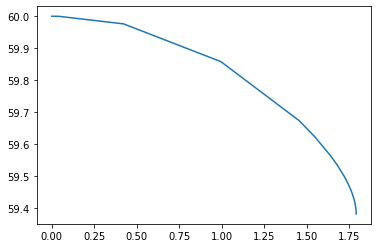

In [26]:
plt.plot(solve_ivp_rk45.t, solve_ivp_rk45.y[0], label=f'$X_{0}(t)$')

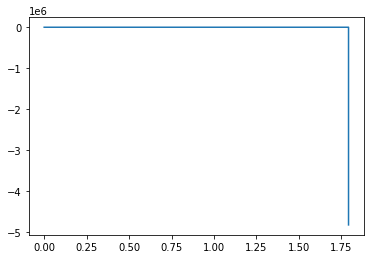

In [27]:
plt.plot(solve_ivp_rk45.t, solve_ivp_rk45.y[1], label=f'$X_{1}(t)$')

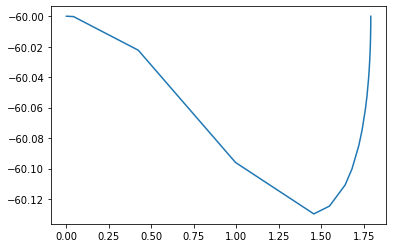

In [28]:
plt.plot(solve_ivp_rk45.t, solve_ivp_rk45.y[2], label=f'$X_{2}(t)$')

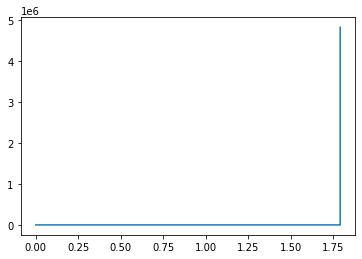

In [29]:
plt.plot(solve_ivp_rk45.t, solve_ivp_rk45.y[3], label=f'$X_{3}(t)$')